# Face Recognition Project

We are going to extract the relevant information from face images and attempt label the images correctly.  We are going to create a data set of faces to train a classifier that can recognize specific people. In this project we are going to make some use of [OpenCV](https://opencv.org/), library for Computer Vision applications.  

## 1. Importing the Data

I used data from [here](http://www.cs.toronto.edu/~guerzhoy/320/proj3/faces_subset.txt), compiled by Michael Guerzoy for his class from the University of Toronto. The dataset is a subset of the much larger [FaceScrub](http://vintage.winklerbros.net/facescrub.html) data set. The file `faces_subset.txt` is in the current folder and contains actors' names, unique URLs of pictures of those actors, and a list of 4 numbers to help crop the images to capture the faces only. We are going to use this file to download the images to then crop them.  There are a total of 10 different actors in the dataset.

Our list of tasks to get the images:

> - Load the `faces_subset.txt` file into a `faces_df` data frame. 
- Create 2 folders: "uncropped" and "cropped" in the current directory. We are going to use those folders to store the images. 
- Before downloading, create a new column to the `faces_df` data frame that will contain the file names of each image that we will download locally. The file names should capture the actor names, the image index (an integer) and the file format extension. For example, the first row actor and URL is:
```
Aaron Eckhart http://upload.wikimedia.org/wikipedia/commons/5/5d/AaronEckhart10TIFF.jpg
```
so we will use the format  `Aaron_Eckhart1.jpg` as the file name for the image saved from that URL.

> - Download the images and store locally them with a unique file name in the "uncropped" folder. We will clean and crop the raw data later and store them in the "cropped folder"


In [2]:
## Import Libraries
import cv2
import pandas as pd
import numpy as np

In [3]:
## Import the table as a dataframe, we only need the 3 columns as below

faces_df = pd.read_table("./faces_subset.txt", header=None,usecols=[0,3,4],names=["Actor","URL","crop"])
faces_df.head()

,Actor,URL,crop
0,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...,"53,177,418,542"
1,Aaron Eckhart,http://movies.dosthana.com/sites/default/files...,"80,102,260,282"
2,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...,"203,802,975,1574"
3,Aaron Eckhart,http://25.media.tumblr.com/nJ2vga5sae9o2ks4Flt...,"62,90,231,259"
4,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...,"276,120,492,336"


In [4]:
# Create 'filename' column for each of the images.
# I used a vectorized splitext function from the 'os.path' module
# to get the file extension names since they are not all the same

import os.path
vfunc = np.vectorize(os.path.splitext)

faces_df["filename"]=(faces_df["Actor"].str.split().str.get(0)+
                      "_"+
                      faces_df["Actor"].str.split().str.get(1)+
                      pd.Series(faces_df.index+1).astype(str)+
                      pd.Series(vfunc(faces_df["URL"])[1])) 

In [5]:
faces_df["filename"].head()

0    Aaron_Eckhart1.jpg
1    Aaron_Eckhart2.jpg
2    Aaron_Eckhart3.jpg
3    Aaron_Eckhart4.jpg
4    Aaron_Eckhart5.jpg
Name: filename, dtype: object

#### Time Out Function
The following code from the [Active State Website](http://code.activestate.com/recipes/473878-timeout-function-using-threading/)  allows us to download the images from the URL to a specified local folder 

In [6]:
import urllib.request
import threading

def timeout(args=(), kwargs={}, timeout_duration=30, default=None):
    '''From:
    http://code.activestate.com/recipes/473878-timeout-function-using-threading/'''
    
    class InterruptableThread(threading.Thread):
        def __init__(self):
            threading.Thread.__init__(self)
            self.result = None

        def run(self):
            try:
                urllib.request.urlretrieve(*args)
            except:
                self.result = default

    it = InterruptableThread()
    it.start()
    it.join(timeout_duration)
      
    if it.isAlive():
        return False
    else:
        return it.result

In [7]:
## Apply timeout function to download raw photos

faces_df.apply(lambda x: timeout([x["URL"],"./uncropped/"+x["filename"]]),axis=1)

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
        ...  
2135    False
2136     None
2137     None
2138     None
2139     None
2140     None
2141     None
2142     None
2143     None
2144     None
2145     None
2146     None
2147     None
2148     None
2149     None
2150     None
2151     None
2152     None
2153     None
2154     None
2155     None
2156     None
2157     None
2158     None
2159     None
2160     None
2161     None
2162     None
2163     None
2164     None
Length: 2165, dtype: object

There were 2164 images in the dataframe, but not all of the will download, since some of the links are broken now or no longer in use.

### 1.2 Cropping and Resizing the Images


We want to focus on the faces of the actors, since the raw photos contain much more than just the actors' faces.  To remove any unnnecessary information, we are going to crop the raw photos around the center of the face and resize them into a a $64\times64$ pixel array.  We going to convert the images to grayscale so at each pixel coordinate, it will just contain a single value so the data will be easier to deal with.  


In the 'crop' column in the `faces_df` data frame are a list of 4 numbers in the form (x1,y1,x2,y2), where 

* (x1,y1) are the pixel coordinates of the lower left corner of the crop, 
* (x1,y2) are the pixel coordinates of the upper left corner of the crop,
* (x2,y1) are the pixel coordinates of the lower right corner of the crop,
* (x2,y2) are the pixel coordinates of the upper right corner of the crop.


We will use this to write a function that will take in the 'crop' column, crop the raw photos in the "uncropped" folder where we downloaded initially and then use `cv.2imwrite` to store them in the cropped folder.   

The `cv2.imread` function reads the raw photo image as a grayscale image and returns a numpy array with the original dimensions, so for a raw image array `img`, `img[y1:y2,x1:x2]` will return the cropped version.  A visual example of the `imread` function is shown below.  A grayscale image with 9 pixels has an associated intensity value for each pixel is converted to a numpy array.

<img src="imread.png",width=500>

In [8]:
## TODO: write the crop function
## I use a try-except method to return None if the image does not exist in the "uncropped" folder

def crop(filename, param):
    try:
        img = cv2.imread("./uncropped/" + filename, flags=0)
        
        x1 = int(param.split(",")[0])
        y1 = int(param.split(",")[1])
        x2 = int(param.split(",")[2])
        y2 = int(param.split(",")[3])
        
        crop = img[y1:y2,x1:x2]
        
        crop = cv2.resize(crop,(64,64))
        
        cv2.imwrite("./cropped/" + filename,crop)
    except:
        return
    

In [9]:
# Apply the crop function

faces_df.apply(lambda x: crop(x["filename"],x["crop"]),axis=1)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
2135    None
2136    None
2137    None
2138    None
2139    None
2140    None
2141    None
2142    None
2143    None
2144    None
2145    None
2146    None
2147    None
2148    None
2149    None
2150    None
2151    None
2152    None
2153    None
2154    None
2155    None
2156    None
2157    None
2158    None
2159    None
2160    None
2161    None
2162    None
2163    None
2164    None
Length: 2165, dtype: object

## 1.3 Creating the master dataframe

Almost there! We need now to load all images into a large data frame to be able them as data. The $64\times64$ pixeled pictures will be flatted into a $1\times4096$ array where each pixel point corresponds to a feature. 

We are going to write 3 functions to do create the dataframe:
* The first function `normalize` will scale each pixel value in the photo such that the maximum value is 1 and the minimum value is 0. 
* The function `load_image` will load the image, normalize it, flatten it into a 1-dimentional array and return this array as a pandas Series. 
* The last function `load_image_flip` will do the same thing than `load_image` but will flip the image around the y-axis to augment the data with the flipped version of each image. Using the flipped images will give more data for our classifier to train on since faces are assumed symmetrical.

In [7]:
## TODO: write the load_image function

## This is just taking each pixel and minusing the
## minimum value and dividing by the range

def normalize(im):
    mn = min(im)
    mx = max(im)
    r = mx - mn
    return (im - mn)/r  # 

In [8]:
## TODO: write the load_image function

def load_image(filename):
    try:
        img = cv2.imread("./cropped/" + filename,flags=0)
        
        img = np.ndarray.flatten(img)
        
        norm = normalize(img)
        
        return pd.Series(norm)
    except:
        return pd.Series()

In [9]:
## TODO: write the load_image_flip function

def load_image_flip(filename):
    try:
        img = np.fliplr(cv2.imread("./cropped/" + filename,flags=0))
        
        img = np.ndarray.flatten(img)
        
        norm = normalize(img)
        
        return pd.Series(norm)
    except:
        return pd.Series()

#### 1.3.1 Create 2 data frames corresponding to original image and flipped image data

We will apply both `load image` `and load_image_flip` functions separate to images of the "cropped" folder to create two data frames where each row correspond to an image and each column corresponds to a pixel. We also add in the name of the actor for each row of the dataframes using the `pd.assign` function. We finally combine the dataframes together into a master `all_faces_df` dataframe. The data frame should contain twice as many rows as there are images since we augmented the data with the flipped version of each image. After removing null rows, the dataframe will be ready to use for our classifier. 

In [14]:
## The resulting frame will contain data for all the original pictures

df1 = faces_df["filename"].apply(load_image).assign(Names = faces_df["Actor"])
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Names
0,0.773481,0.596685,0.486188,0.464088,0.475138,0.508287,0.441989,0.414365,0.375691,0.309392,...,0.375691,0.243094,0.248619,0.243094,0.232044,0.226519,0.215470,0.281768,0.265193,Aaron Eckhart
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Eckhart
2,0.036000,0.032000,0.048000,0.044000,0.028000,0.124000,0.052000,0.112000,0.064000,0.108000,...,0.404000,0.452000,0.372000,0.408000,0.388000,0.272000,0.308000,0.284000,0.300000,Aaron Eckhart
3,0.343348,0.244635,0.103004,0.120172,0.158798,0.231760,0.201717,0.188841,0.150215,0.188841,...,0.463519,0.587983,0.678112,0.751073,0.995708,0.068670,0.090129,0.120172,0.107296,Aaron Eckhart
4,0.221739,0.173913,0.130435,0.139130,0.178261,0.182609,0.247826,0.308696,0.334783,0.365217,...,0.221739,0.217391,0.208696,0.191304,0.165217,0.143478,0.134783,0.139130,0.147826,Aaron Eckhart


In [15]:
## The resulting frame will contain data for all the  pictures

df2 = faces_df["filename"].apply(load_image_flip).assign(Names = faces_df["Actor"])
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Names
0,0.425414,0.430939,0.441989,0.491713,0.320442,0.563536,0.546961,0.458564,0.480663,0.541436,...,0.110497,0.110497,0.082873,0.132597,0.237569,0.342541,0.486188,0.740331,0.861878,Aaron Eckhart
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Eckhart
2,0.428000,0.372000,0.448000,0.432000,0.468000,0.420000,0.500000,0.436000,0.448000,0.476000,...,0.024000,0.024000,0.024000,0.024000,0.020000,0.020000,0.020000,0.020000,0.020000,Aaron Eckhart
3,0.553648,0.935622,0.789700,0.557940,0.227468,0.171674,0.163090,0.253219,0.360515,0.502146,...,0.042918,0.047210,0.051502,0.051502,0.047210,0.042918,0.034335,0.025751,0.021459,Aaron Eckhart
4,0.147826,0.139130,0.160870,0.156522,0.195652,0.221739,0.282609,0.295652,0.317391,0.295652,...,0.230435,0.234783,0.230435,0.278261,0.239130,0.273913,0.317391,0.352174,0.356522,Aaron Eckhart


#### 1.3.2 The Master Dataframe
The following 'all_faces_df' is the dataframe we will work with

In [19]:
# Combine the two dataframes and remove null rows

all_faces_df = pd.concat([df1,df2],ignore_index=True)
all_faces_df.dropna(inplace=True)
all_faces_df.head()



,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Names
0,0.773481,0.596685,0.486188,0.464088,0.475138,0.508287,0.441989,0.414365,0.375691,0.309392,...,0.375691,0.243094,0.248619,0.243094,0.232044,0.226519,0.215470,0.281768,0.265193,Aaron Eckhart
2,0.036000,0.032000,0.048000,0.044000,0.028000,0.124000,0.052000,0.112000,0.064000,0.108000,...,0.404000,0.452000,0.372000,0.408000,0.388000,0.272000,0.308000,0.284000,0.300000,Aaron Eckhart
3,0.343348,0.244635,0.103004,0.120172,0.158798,0.231760,0.201717,0.188841,0.150215,0.188841,...,0.463519,0.587983,0.678112,0.751073,0.995708,0.068670,0.090129,0.120172,0.107296,Aaron Eckhart
4,0.221739,0.173913,0.130435,0.139130,0.178261,0.182609,0.247826,0.308696,0.334783,0.365217,...,0.221739,0.217391,0.208696,0.191304,0.165217,0.143478,0.134783,0.139130,0.147826,Aaron Eckhart
5,0.631579,0.680162,0.724696,0.291498,0.396761,0.194332,0.380567,0.396761,0.388664,0.283401,...,0.052632,0.048583,0.056680,0.044534,0.040486,0.052632,0.044534,0.040486,0.064777,Aaron Eckhart


In [20]:
print(all_faces_df.shape)

(2792, 4097)


We will have 2792 total face images four dataset to train the Random Forest Classifier

## 1.4 Plot the "average" face

If we take the mean of every column (which corresponds to every pixel) in our master dataframe, and read it back into an image, this shold give us an "average" face.

C:\Users\Alex\Anaconda3\envs\dscsulb\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


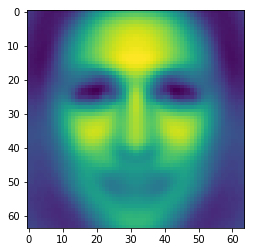

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

## TODO: Plot the avrage face

avg = all_faces_df.mean(numeric_only=True)
avgimage = np.reshape(avg,(64,64))
plt.imshow(avgimage)

# 2. Learning the Faces

We are going now to train the various Random Forest algorithms ([1](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm), [2](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)) to this data to classify the 10 actors' faces.

>- First use the [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to encode the column containing the names. 
>- Split the dataset into features and target column


The target names are still strings, so we will use the label encode the names

In [21]:
## Import libraries

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#### Encode the target names

The target names are still strings, so we will use the label encode the names

In [23]:
le = LabelEncoder()

le.fit(all_faces_df["Names"])
le.transform(all_faces_df["Names"])

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [24]:
## Change the names to their labels

all_faces_df["Names"] = le.transform(all_faces_df["Names"])

#### Split the features and target columns

In [50]:
## Split features and targert 

X = all_faces_df.drop(["Names"],axis=1)
y = all_faces_df["Names"]

## 2.1 Fit an initial Random Forest Algorithm

1. Fit Random Forests for `n_estimators=100` and for different various values of the Random Forest's `max_features` argument between 1 and 4096 (the total number of features) and plot those accuracies as a function of `max_features`.
- Recompute the accuracy for the `max_features` value that yields that best performance but this time set `n_estimators=1000`.

The inputs will be a matrix of flatten images and the target will be encoded version of the names. Random Forest by construct, allows to estimate the generalization error without crossvalidating. If you set the argument `oob_score=True`, the `oob_score_` attribute will be the estimation of accuracy. This is due to RF using the [Bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) (Bootstrap aggregating) process. At training time, RF creates boostrap samples and not all the original samples belong the data used by RF. You can prove that only ~63.2% of the original data for each tree is used, leaving ~26.8% of data to estimate the performance of each tree. This remaining data is called the out of bag (OOB) data and the performance if called the out of bag performance.


In [29]:
## TODO: Create different values of max_features

Ms = np.arange(2,3600,100)
Ms

array([   2,  102,  202,  302,  402,  502,  602,  702,  802,  902, 1002,
       1102, 1202, 1302, 1402, 1502, 1602, 1702, 1802, 1902, 2002, 2102,
       2202, 2302, 2402, 2502, 2602, 2702, 2802, 2902, 3002, 3102, 3202,
       3302, 3402, 3502])

In [28]:
## TODO: for each max_feature parameter value fit a random forest

scores = []

for m in Ms:
    clf = RandomForestClassifier(n_estimators=100,
                               max_features=m,
                               oob_score=True,
                               random_state=42,
                               n_jobs=-1)
    clf.fit(X,y)
    
    # add scores to scores for each M
    scores.append((m,clf.oob_score_))


### 2.1.2 Plot accuracy as a function of max_features parameter

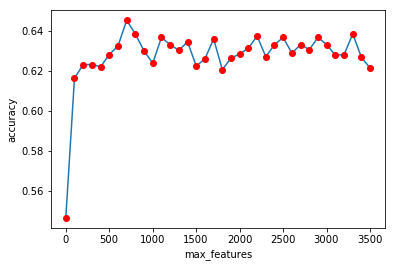

In [40]:
plt.plot(*zip(*scores))
plt.plot(*zip(*scores),"or")
plt.xlabel("max_features")
plt.ylabel("accuracy")
plt.show()

In [43]:
## Find the parameter that yields highest accuracy score

[item for item in scores if item[1] == max(b)]

[(702, 0.64541547277936961)]

* `max_feature` parameter of 702 yields highest accuracy score of 0.64542...

## 2.2 Fit Random Forest Algorithm for `n_estimators` = 1000 and `max_features` = 702

Now we increase paramater of `n_estimators` to 1000 and use the `max_feature` parameter to 702 as we found earlier

In [44]:
# Fit a second random forest with max_features from earlier

clf2 = RandomForestClassifier(n_estimators=1000,
                               max_features=702,
                               oob_score=True,
                               random_state=42,
                               n_jobs=-1)

In [46]:
clf2.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=702, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [47]:
# Print the score

clf2.oob_score_

0.6855300859598854

An accuracy of 0.68553 is an improvement from the previous section

## 2.3 Feature transformation: Scaling / PCA

The computation is quite slow and the performance is not that great. We try improving both problems by transforming the data into the principal component basis. We are going to apply a [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transformation for different numbers of principal components, and then train Random Forest on the transformed data, and then try to find the optimal number of prinicple components.

We are also going to use the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which removes the mean from each picture data and scales the data to unit variance. We are going to use the [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) process to stack the transformation of the data and the algorithm fitting step one after another. We cannot use the Out of Bag accuracy anymore from Random Forest as the PCA and scaling transformations are part of the process (there would be some insampling problems). 

1. Create few values for `n_components` between 1 and 500.  Iterate though those values to select different numbers of principal components to use in training. 
- For each of those `n_components`, create 2 pipelines: one of `StandardScaler`, `PCA` and Random Forest and one with just `PCA` and Random Forest only.
- Use `StratifiedKFold` to split the data into 10 folds. Use the `split` function to iterate thought the folds and split the data into train and test sets. Use `random_state=42`.
- Use the [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to compute the average of the 10-fold stratified cross validation accuracy scores for the different values of `n_components` parameter. 
- Plot those accuracies as a function of `n_components` to find the optimal number of Principle Components. We set the Random Forest's `n_estimators` to 1000.


In [25]:
# Import libraries

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

In [27]:
# Choose values for the n_components parameter to test

Ns = np.arange(1,500,25)
Ns

array([  1,  26,  51,  76, 101, 126, 151, 176, 201, 226, 251, 276, 301,
       326, 351, 376, 401, 426, 451, 476])

#### Get CV scores for transformed data

Applying the pipelines allows us to transform the data and fit the random forest algorithm seamlessly. We will transform the data with 2 methods: one with just a PCA transformation and one with a PCA & Standard Scaler transformation.

In [31]:
result1=[] ## CV accuracy scores for PCA & RF classifier only
result2=[] ## CV accuracy scores for SS, PCA & RF classifier 

for n in Ns:
    ## TODO: Set a pipeline of PCA and Random forest and another of StandardScaler, PCA and Random forest
    pca = PCA(n_components=n, whiten=True)
    rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    ss=StandardScaler()
    
    pl1=Pipeline([('pca', pca), ('rf', rf)])  
    pl2=Pipeline([('ss', ss), ('pca', pca), ('rf', rf)])  

    
    ## TODO: Compute the 10 fold-CV accuracy with stratified sampling for different values of n_components
    skf=StratifiedKFold(10, shuffle=True, random_state=42)
    
    ## Apply the cross_val_score function and append the average CV accuracy scores
    result1.append(cross_val_score(pl1, X, y, scoring="accuracy", cv=skf, n_jobs=-1).mean())
    result2.append(cross_val_score(pl2, X, y, scoring="accuracy", cv=skf, n_jobs=-1).mean())

### 2.3.1 Plot of accuracy vs the `n_components`

#### PCA and Random Forest Only Pipeline

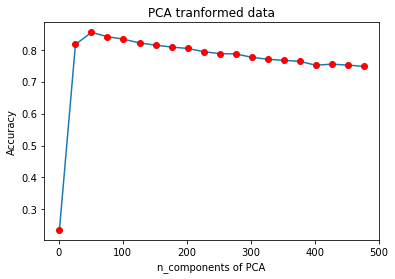

In [53]:
## Plot the number of PCA components vs. accuracy
plt.plot(Ns,result1)
plt.plot(Ns,result1,"or")
plt.ylabel("Accuracy")
plt.xlabel("n_components of PCA")
plt.title("PCA tranformed data")



#### Standard Scaler, PCA, and Random Forest Pipeline

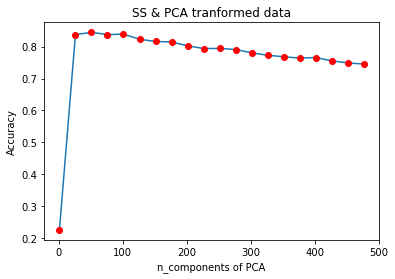

In [52]:
plt.plot(Ns,result2)
plt.plot(Ns,result2,"or")
plt.ylabel("Accuracy")
plt.xlabel("n_components of PCA")
plt.title("SS & PCA tranformed data")

In [46]:
pd.DataFrame({'PCA only':result1,'PCA & SS':result2},index=Ns)

,PCA & SS,PCA only
1,0.225304,0.235120
26,0.837720,0.816806
51,0.844886,0.854836
76,0.837788,0.841234
101,0.839248,0.833320
126,0.823192,0.821595
151,0.816331,0.814696
176,0.814560,0.808685
201,0.802740,0.804328
226,0.794111,0.794312


* For the PCA transformed data, the highest accuracy is at `n_components = 51` with a mean accuracy score of 0.854
* For the SS and PCA transformed data the highest accuracy is at `n_components = 51` with a mean accuracy score of 0.845
* The accuracy varies negligibly between the 2 pipelines.

Using PCA to our picture data gives improved accuracy for our classifier.

## 2.4. Random Forest with PCA & Feature Selection

It is quite possible that the first initial principal components are not actually the most optimal features to choose for Random Forest. We are going to select this time the best features by looking at the `feature_importances_` attribute of Random Forest. This time it is difficult to use the Pipeline along with the cross_val_score function therefore we are going to write our own cross-validation process.

1. We are going to use `StratifiedKFold` to split the data into 10 folds. Use `random_state=42` (the same than the previous section).
- For each fold, create a pipeline of `StandardScaler` and `PCA` with `n_components=500`. For each fold fit this pipeline with the train set and transform the train and test sets. This step is to ensure that we have enough principal components to evaluate. 
- Perform a first Random Forest fit and capture the feature importance using the Random Forest's `feature_importances_` attribute. The features correspond to the columns in the PCA transformed dataset.
- Perform a second Random Forest fit but this time, only using the $n$ best features where $n$ was the number for `n_components` in the previous section (2.1) that yielded the best performance.
- For each fold, measure the accuracy on the test set.
- Average the results for the all the folds and compare the performance with the previous section

In [ ]:
## TODO: We are going to use StratifiedKFold to split the data into 10 folds

skf = StratifiedKFold(n_splits=10, random_state=42)

#### Find CV Scores for the feature selected RF classifier

In [506]:
result = [] # list to hold accuracy scores for each fold

## TODO: Use the split function to iterate thought the folds.
for train_index, test_index in skf.split(X, y):
    
    ## TODO: split the data into train and test sets
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    
    ## TODO: create a pipeline of StandardScaler and PCA with n_components=500, whiten=True
    pca = PCA(n_components=500, whiten=True)
    ss=StandardScaler()
    pl=Pipeline([('ss', ss), ('pca', pca)])
     
    ## TODO: fit this pipeline with the train set and transform the train and test sets.
    X_train_pc = pl.fit(X_train).transform(X_train)
    X_test_pc  = pl.fit(X_train).transform(X_test)

      
    ## TODO: Perform a first Random Forest fit
    rfc1 = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
    rfc1.fit(X_train_pc,y_train)
    
    ## TODO: capture the feature importance using the Random Forest's feature_importances_ attribute
    ## This corresponds to the best 50 columns to use from the PCA transformed data
    important = pd.Series(rfc1.feature_importances_).nlargest(50).index
       
    ## TODO: Perform a second Random Forest fit with the best features from feature_importances_ 
    rfc2 = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
    rfc2.fit(X_train_pc[:,important],y_train)
    
    ## TODO: measure the accuracy on the test set for each fold
    result.append(rfc2.score(X_test_pc[:,important],y_test))
    


In [512]:
## TODO: Average the results for the all the folds and compare the performance with the previous section
np.array(result).mean()

0.90290558727592818

* An average accuracy score of 0.902 is a huge improvement from the previous sections

## 3. Principal Component Analysis for Face recognition

We are going to use PCA to recognize if an image if a picture of a human face or not. A set of "eigenfaces" can be generated by  principal component analysis (PCA) on a large set of images depicting different human faces.

Informally, eigenfaces can be considered a set of "standardized face ingredients". A human face can be considered to be a combination of these standard faces, analogous to basis vectors spanning a vector space. For example, one's face might be composed of the average face plus 10% from eigenface 1, 55% from eigenface 2, and even -3% from eigenface 3. Remarkably, it does not take many eigenfaces combined together to achieve a fair approximation of most faces. Also, because a person's face is not recorded by a digital photograph, but instead as just a list of values (one value for each eigenface in the database used), much less space is taken for each person's face.

In [48]:
## Fit the PCA compoenents

pca = PCA(n_components=30)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [49]:
# List the eigenfaces

pca.components_

array([[ 0.02116823,  0.02154109,  0.02197237, ...,  0.01714076,
         0.01723351,  0.01761446],
       [-0.01219513, -0.01279761, -0.01355447, ...,  0.01534039,
         0.01494865,  0.01441999],
       [ 0.0195338 ,  0.01916975,  0.01902669, ...,  0.02034289,
         0.02122534,  0.02101996],
       ..., 
       [-0.02200946, -0.02374744, -0.01923942, ...,  0.02877721,
         0.02919896,  0.03369161],
       [-0.0023695 ,  0.00197472, -0.00646484, ..., -0.01086438,
        -0.02202473, -0.0274581 ],
       [-0.01766375, -0.01394642, -0.01007189, ..., -0.02428718,
        -0.01681778, -0.00760654]])

The array above contains the 50 "eigenfaces"

#### Plot the first 10 eigen faces

We reconstruct the first 10 eigenfaces since they still in a $1\times4096$ array. The eigenfaces encapsulate the areas of the faces where there is most variance.  

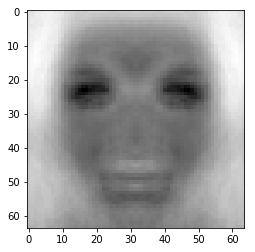

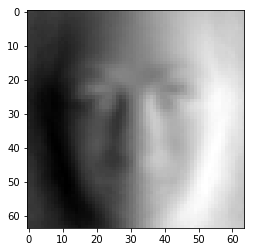

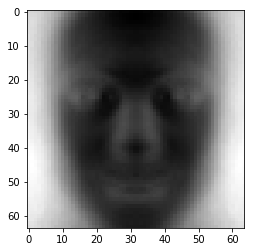

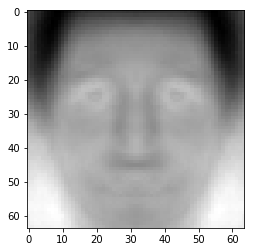

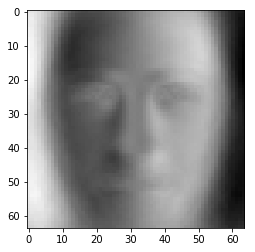

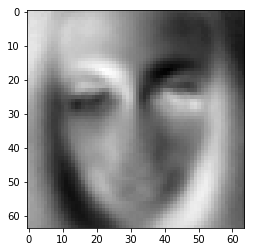

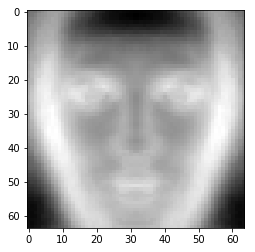

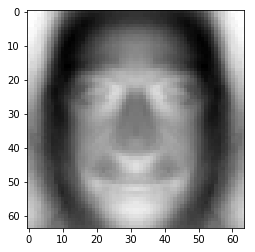

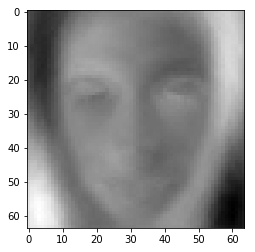

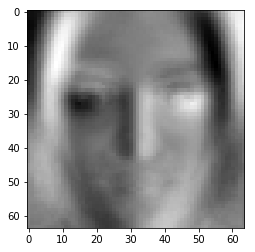

In [593]:
eigenfaces = pca.components_

for x in eigenfaces[:10]:
    img = np.reshape(x, [64,64])
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

## 3.2 Image reconstruction

We are now going to project some sample images onto the principal component basis learned with our original data set and reconstruct the images in the original basis. Only images that are well described by the eigen faces basis should be well reconstructed.

1. Fit PCA to the original data with a 30 components. 
- For each image in the "additional_images/test_face_recognition" folder use the `transform` and `inverse_transform` functions to project the image into the PCA basis and then reconstruct the image into the original basis. For each image, you will need to apply the same transformations you have done to the original data.
- For each original and reconstructed image compute the $RMSE=\sqrt{\overline{(original - reconstructed)^2}} $
- Plot each image and its reconstructed version.

If the RMSE is low, this suggests the image is a face

In [64]:
#Import libraries

import os
from sklearn.metrics import mean_squared_error as mse

In [62]:
# Get the list of all images by their directory and file names

folder = "./additional_images/test_face_recognition/"

all_files = os.listdir(folder)

### Fit the PCA

In [ ]:
pca = PCA(n_components=30)
pca.fit(X)

### Plot the image and the reconsctruction

car1.jpg


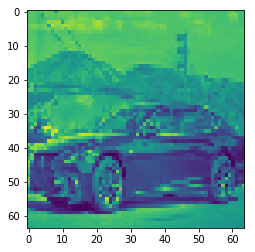

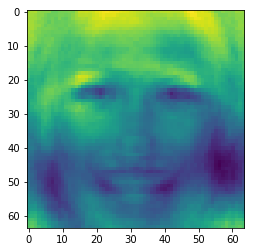

RMSE =  0.147552814025 



car2.jpeg


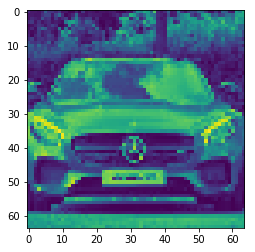

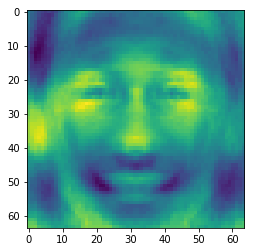

RMSE =  0.210685596889 



car3.jpeg


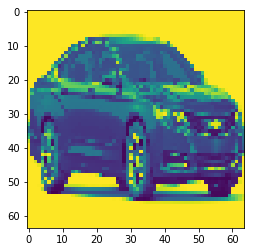

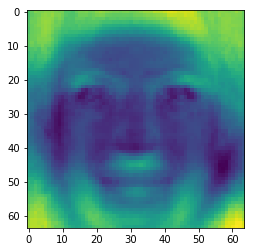

RMSE =  0.23737593896 



cat1.jpeg


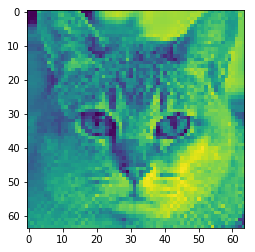

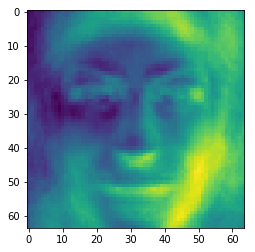

RMSE =  0.144527500171 



cat2.jpeg


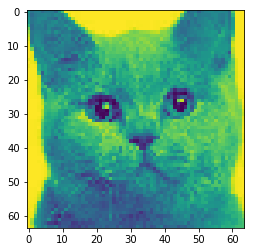

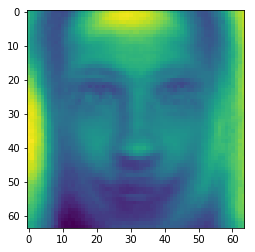

RMSE =  0.135177732203 



cat3.png


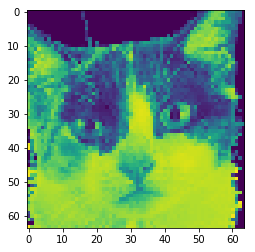

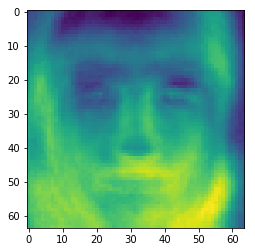

RMSE =  0.187458335446 



dog1.jpeg


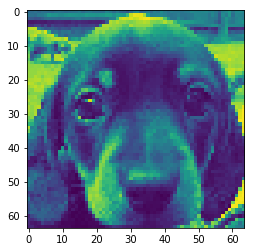

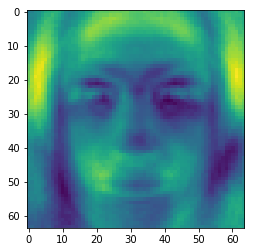

RMSE =  0.188605320403 



dog2.jpg


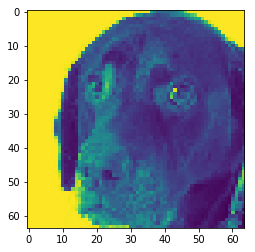

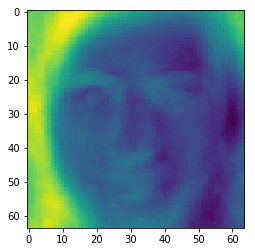

RMSE =  0.156787062824 



dog3.jpeg


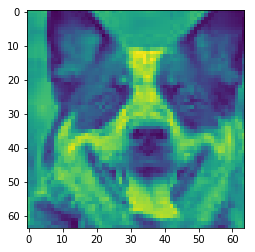

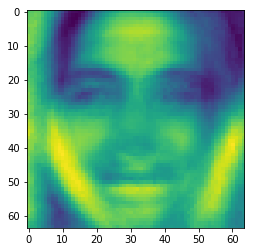

RMSE =  0.175449301348 



face1.jpg


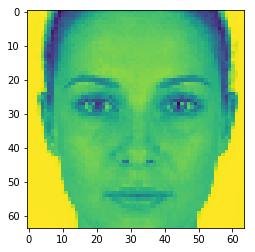

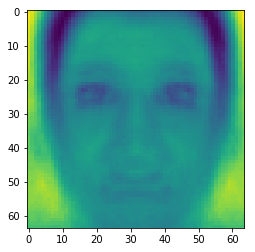

RMSE =  0.0889391501418 



face2.jpeg


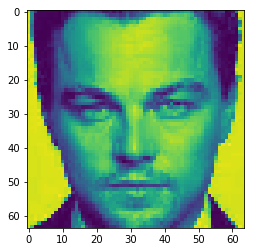

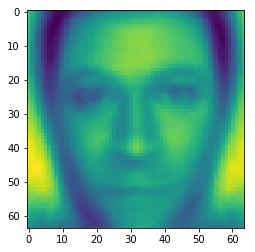

RMSE =  0.180140258642 



face3.jpg


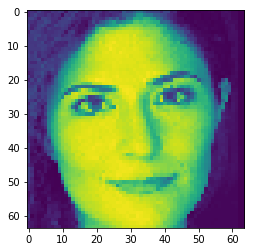

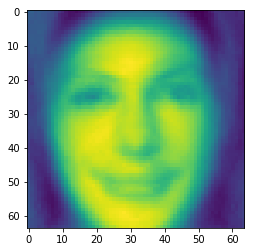

RMSE =  0.103423133876 



face4.jpg


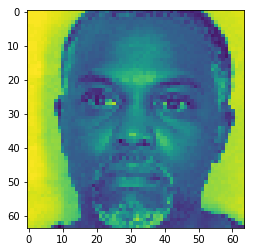

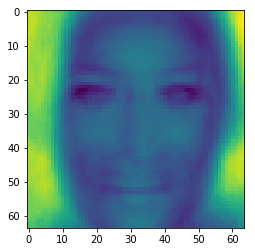

RMSE =  0.125438357301 



face5.jpg


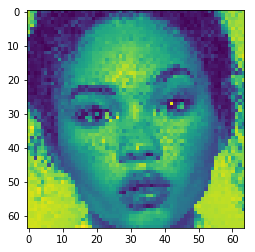

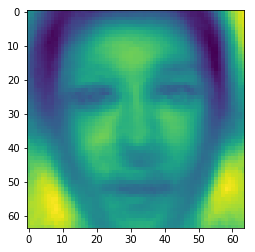

RMSE =  0.140920846025 



face6.jpg


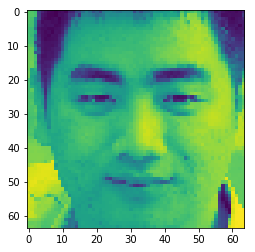

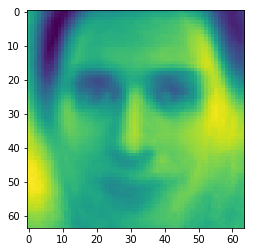

RMSE =  0.117485649472 



face7.jpg


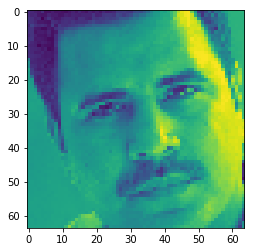

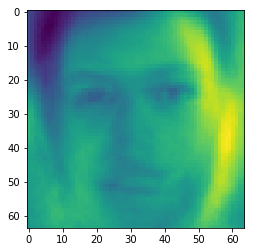

RMSE =  0.106871225023 



flower1.jpeg


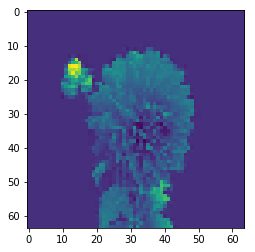

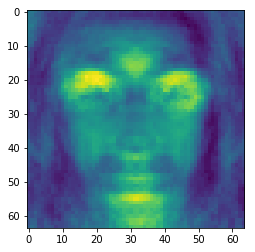

RMSE =  0.0913673132299 



flower2.jpeg


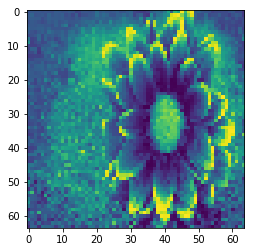

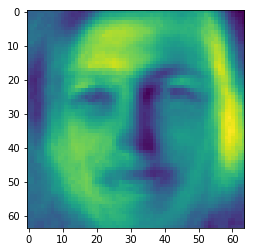

RMSE =  0.191121241522 



flower3.jpg


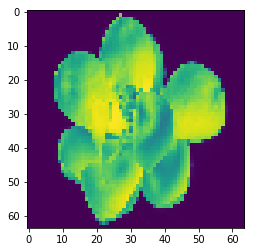

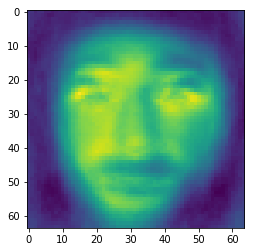

RMSE =  0.202899233294 





In [719]:
for f in all_files:
    ## TODO: Plot each image and it reconstructed version
    print(f)
    img = cv2.imread(folder + f,flags=0) #read image from folder
    img2 = cv2.resize(img,(64,64)) #resize to 64 by 64
    img3 = normalize(np.ndarray.flatten(img2)) #flatten and normalize
    plt.imshow(img3.reshape(64,64)) #reshape back to 64 by 64 array to plot
    plt.show()
    
    transformed = pca.transform(img3.reshape(1,-1)) # plot the photo to the eigenfaces
    inv_transform = pca.inverse_transform(transformed) #reconstruct back
    plt.imshow(inv_transform.reshape(64,64)) #reshape reconstructed to 64 by 64 to plot 
    plt.show()
    print('RMSE = ',np.sqrt(mse(img3,inv_transform[0])),'\n\n\n')

* `n_components` = 30 and a threshold RMSE of around 0.13 seems reasonable to distinguish faces.  The problem with eigenfaces is that test faces need to be perfectly cropped and rotated to be symmetrically. The shape, size, lighting, and orientation of the faces should be roughtly equivalent to predict more accurately

## 4. Learning gender

We are going to try to classify the faces according to their actor's or actress's gender.

#### Create a dictionary that maps from actor to their genders and map to the target
I arbitrarily chose males = 0 and females = 1

In [742]:
# Get the names so we can create the dictionary

le.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['Aaron Eckhart', 'Adam Brody', 'Adam McKay', 'Adam Sandler',
       'Adrien Brody', 'Andrea Anders', 'Ashley Benson',
       'Christina Applegate', 'Dianna Agron', 'Gillian Anderson'], dtype=object)

In [758]:
# Create the dictionary that maps the the actor number to their gender

gender_dict = dict(zip([0,1,2,3,4,5,6,7,8,9],[0,0,0,0,0,1,1,1,1,1]))
gender_dict

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}

In [771]:
# Gender will be placed to the true_gender variable

true_gender = all_faces_df["Names"].map(gender_dict1)
true_gender

0       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
10      0
12      0
13      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
26      0
27      0
28      0
29      0
31      0
32      0
33      0
34      0
35      0
36      0
       ..
4270    1
4271    1
4273    1
4279    1
4282    1
4288    1
4290    1
4291    1
4292    1
4293    1
4294    1
4295    1
4297    1
4300    1
4301    1
4303    1
4304    1
4305    1
4308    1
4309    1
4310    1
4313    1
4314    1
4316    1
4318    1
4319    1
4321    1
4326    1
4327    1
4329    1
Name: Names, Length: 2792, dtype: int64

## 4.1 Clustering the faces

Often clustering methods can help supervised learning algorithms learning to create new features. To highlight that we are going to are going to cluster the original data (without the target column) into 2 clusters and compare the results with the genders. We try 3 different algorithms to cluster the faces.  We initally just want to see if the faces will be clustered according to gender.

### 4.1.1 Mini Batch K- Means

In [76]:
# Import libraries

from sklearn.metrics import accuracy_score as acc
from sklearn.cluster import MiniBatchKMeans

In [77]:
# First try mini batch KMeans
cluster1 = MiniBatchKMeans(n_clusters=2,compute_labels=True)

In [83]:
# Fit and predict the cluster 

pred1 = cluster1.fit_predict(X)

array([1, 0, 0, ..., 1, 0, 0])

In [1325]:
# Get score

acc(true_gender,pred1)

0.3524355300859599

Since we can just switch the labels on male and female, accuracy can be yielded as 1-3524 = 0.6475

### 4.1.2 Gaussian Mixture

In [84]:
# Import the library

from sklearn.mixture import GaussianMixture

In [85]:
cluster2 = GaussianMixture(n_components=2)

In [1330]:
# Fit using Gaussian Mixture

cluster2.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [1332]:
# get tehe predicted values
pred = cluster2.predict(X) 

# Get the accuracy score
acc(true_gender,pred)

0.32306590257879658

Again since accurary is less than 0.5, we can switch the arbitarily signs for males and females, accuracy is $1 - 0.323 = 0.677$

### 4.1.3 AgglomerativeClustering

In [80]:
from sklearn.cluster import AgglomerativeClustering

In [81]:
cluster3 = AgglomerativeClustering(n_clusters=2)

In [82]:
cluster3.fit_predict(X)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [1109]:
# Fit & predict the cluster

pred2 = cluster3.fit_predict(X)

In [1110]:
# Get the accuracy score

acc(true_gender,pred2)

0.39469914040114612

Again, we can switch the labels on male or female, so accuracy can be regarded as $1- 0.394 = 0.606$

### 4.1.4 Clustering with transformed data

We will transform the data using the Standard Scaler and PCA and try clustering the faces again.

In [1161]:
# Create the pipeline is PCA and standard scaler

pca = PCA(n_components=50, whiten=True)
ss=StandardScaler()
pl=Pipeline([('ss', ss), ('pca', pca)])

In [1162]:
# Transform the features

X_transformed = pl.fit_transform(X)

In [1163]:
# I used Agglomerative Clustering

cluster4 = AgglomerativeClustering(n_clusters=2)

In [1164]:
# Fit and predict the cluster with transformed data

pred3 = cluster4.fit_predict(X_transformed)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000001E292519510>)

In [1168]:
#Plot the accuracy score 

acc(true_gender,pred3)

0.73173352435530081

There is a significant improvement in accuracy using data transformed with PCA & SS

## 4.2 Predicting Gender

Now we are going to train our random forest classifier.  We create the SS and PCA pipeline as before.  

### 4.1.1 Random Forest Algorithm for Predicting Gender

In [ ]:
# Create pipeline for SS, PCA, and our Random Forest Classifier

pca = PCA(n_components=50, whiten=True)
ss=StandardScaler()
rfc=RandomForestClassifier(n_estimators=1000, n_jobs=-1)

pl=Pipeline([('ss', ss), ('pca', pca),('rfc',rfc)])

We choose some `n_component` values for PCA to for the algorithm to train

In [1213]:
# Choose some n_component values

N2 = [25,50,75,100,200]

In [1214]:
# Continue with the CV scheme as from before to try to find the optimal n_componenets

cv_score=[]

for n in N2:
    
    pca = PCA(n_components=n, whiten=True)
    rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    ss=StandardScaler()

    pl=Pipeline([('ss', ss), ('pca', pca), ('rf', rf)])

    skf=StratifiedKFold(10, shuffle=True, random_state=42)
    cv_score.append(cross_val_score(pl, X, true_gender, scoring="accuracy", cv=skf, n_jobs=-1).mean())

In [1219]:
pd.DataFrame(cv_score,N2)

,0
25,0.935526
50,0.947707
75,0.946993
100,0.945918
200,0.938390


`n_component` of 50 yields highest accuracy score.  We are able to achieve ~94.7% accuracy for our faces dataset using the Random Forest Algorithm

### 4.3 Applying the Algorithm

We are now going to use apply this trained model to the 2 images of various people in the "additional_images/test_gender_recognition" folder. To do so we are to use the [Haar-cascade Detection](https://docs.opencv.org/3.3.0/d7/d8b/tutorial_py_face_detection.html) from opencv. The following code will allow us to capture only the faces within the images and predict their gender:

#### Gender Recognition for image 1

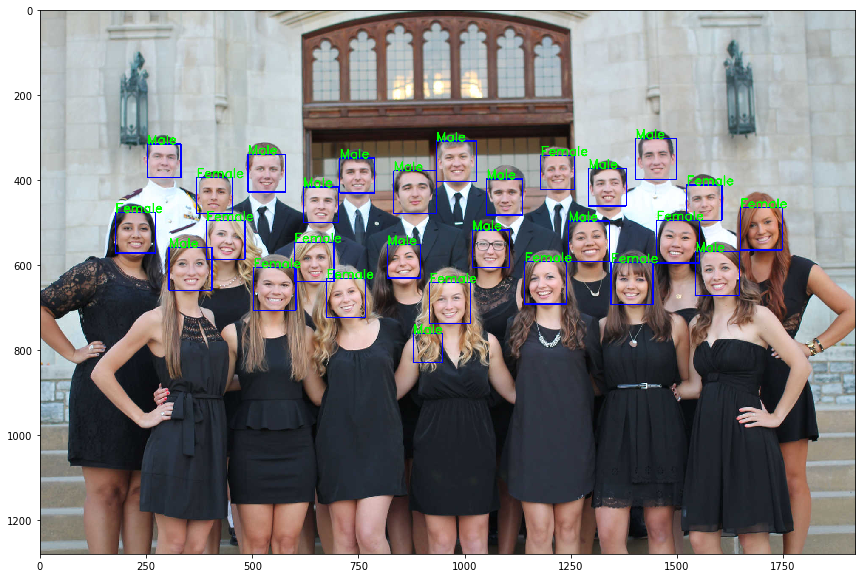

In [1336]:
# We first load the trained AdaBoost model from opencv to recognize face
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# We load the image
img = cv2.imread('./additional_images/test_gender_recognition/image1.jpg')

# We convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# We detect the faces on the image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)


ref = {0:"Male",1:"Female"} # dictionary to map from binary to test 

# For each image we plot a rectangle around the face
for x, y, w, h in faces:
    
    # We plot the rectange
    cv2.rectangle(img,(x, y),(x + w, y + h),(255,0,0),2)
    
    # get the face data
    face = gray[y:y+h,x:x+w]  
    face_data = normalize(np.ndarray.flatten((cv2.resize(face,(64,64)))))
    gender_pred = pl.predict(face_data.reshape(1,-1))[0]  ## predict using model
    
    cv2.putText(img, ref[gender_pred], (x,y), cv2.FONT_HERSHEY_SIMPLEX,  1, (0, 255, 0), 2, cv2.LINE_AA)

# We plot the resulting image
# Opencv reads images as BGR but matplotlib RGB images so we need to convert
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


 19 of the 27 total faces were identified correctly according to gender.
- 9 of the 12 male faces were correctly identified
- 10 of the 15 female faces were correctly identified
 

#### Gender Recognition for image 2

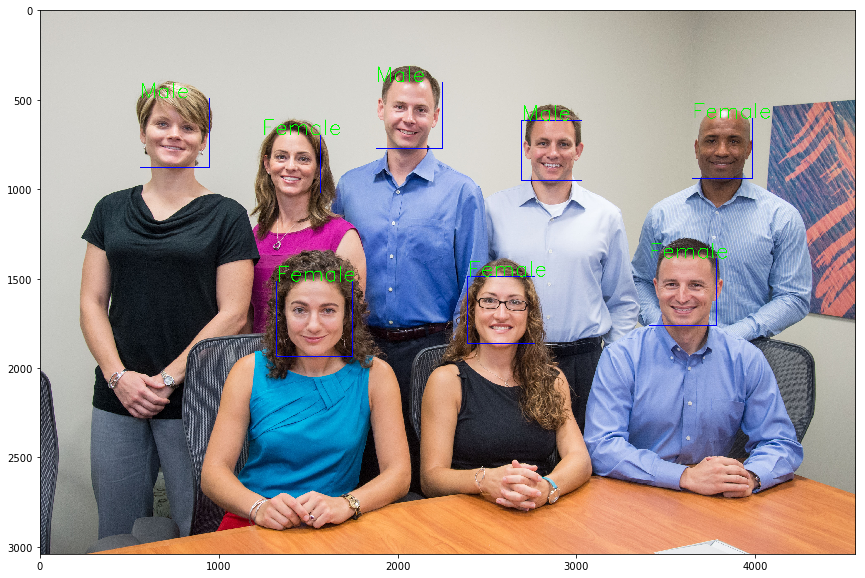

In [1337]:
import cv2
# We first load the trained AdaBoost model from opencv to recognize face
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# We load one of our images
img = cv2.imread('./additional_images/test_gender_recognition/image2.jpg')
# We convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# We detect the faces on the image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)


ref = {0:"Male",1:"Female"} # dictionary to map from binary to test 

# For each image we plot a rectangle around the face
for x, y, w, h in faces:
    # We plot the rectange
    cv2.rectangle(img,(x, y),(x + w, y + h),(255,0,0),2)
    # We write some text
    face = gray[y:y+h,x:x+w] #get the face data
    face_data = normalize(np.ndarray.flatten((cv2.resize(face,(64,64)))))
    gender_pred = pl.predict(face_data.reshape(1,-1))[0]  # predict using model
    
    cv2.putText(img, ref[gender_pred], (x,y), cv2.FONT_HERSHEY_SIMPLEX,  4, (0, 255, 0), 4, cv2.LINE_AA)

# We plot the resulting image
# Opencv reads images as BGR but matplotlib RGB images so we need to convert
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


5/8 of the images were identified correctly.